In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_gen = ImageDataGenerator(rescale=1./255)
import os

In [9]:
path_to_dataset  = "./images"

In [10]:
data = data_gen.flow_from_directory(path_to_dataset, target_size=(224, 224))

Found 20580 images belonging to 120 classes.


In [11]:
X = []
y = []
for _ in range(data.samples // data.batch_size):
    batch_X, batch_y = data.next()
    X.extend(batch_X)
    y.extend(batch_y)
X = np.array(X)
y = np.array(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
output = Dense(data.num_classes, activation='softmax')(x)
model = Model(base_model.input, output)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))


Epoch 1/3


515/515 [==============================] - 1608s 3s/step - loss: 5.2523 - accuracy: 0.1440 - val_loss: 4.9986 - val_accuracy: 0.2070
Epoch 2/3
515/515 [==============================] - 1595s 3s/step - loss: 1.3013 - accuracy: 0.6722 - val_loss: 4.9593 - val_accuracy: 0.2097
Epoch 3/3
515/515 [==============================] - 1572s 3s/step - loss: 0.5414 - accuracy: 0.8537 - val_loss: 4.6686 - val_accuracy: 0.2439


In [15]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)


129/129 [==============================] - 317s 2s/step


In [16]:
print('Confusion Matrix')
print(confusion_matrix(y_test_class, y_pred_class))

Confusion Matrix
[[ 4  0  0 ...  0  0  0]
 [ 0 21  0 ...  0  0  0]
 [ 0  1 19 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  4  0]
 [ 1  0  0 ...  3 15  1]
 [ 1  0  0 ...  0  2 22]]


In [17]:
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print('ROC-AUC score: ', roc_auc)

ROC-AUC score:  0.9043326601979655


In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

In [21]:
y_test_bin = label_binarize(y_test_class, classes=list(range(120)))
y_pred_bin = model.predict(X_test)

129/129 [==============================] - 325s 3s/step


In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(120):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

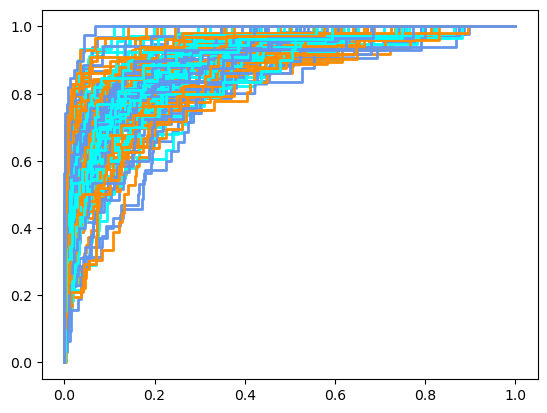

In [23]:
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(120), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


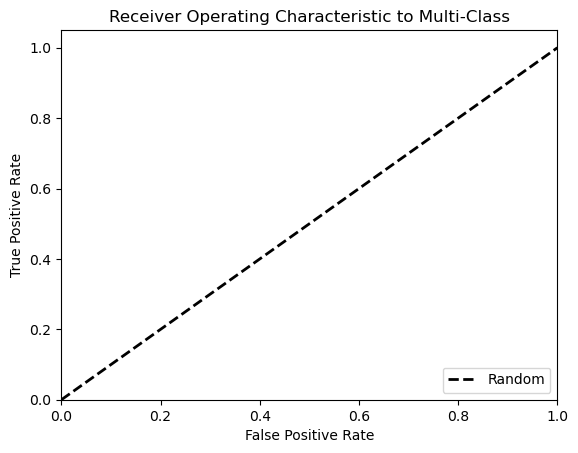

In [25]:
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()